<a href="https://colab.research.google.com/github/florian-frey/AudioSimilarity/blob/main/src/DimesionalityReductionSpec/C(V)AE_ASS_grayscale_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genre Classifier based on Spectrograms of the FMA Dataset

# 0 Concept explanation

## 0.1 Introduction:

This notebook will take the spectrogram images as an input and train several (variational) autoencoders. The goal of this is to reduce the number of dimensions from the original image (respectivly the original audio data), in order to ensure latent querys it in a vector database, whereas keeping most of the information of the original data.

## 0.2 Sources:
- https://www.tensorflow.org/tutorials/generative/cvae
- https://keras.io/examples/generative/vae/

# 1 Setup

## 1.1 Imports

In [ ]:
# update tensorflow to latest version
!pip uninstall -q -y tensorflow
!pip install -q tensorflow==2.13

Found existing installation: tensorflow 2.13.0
Uninstalling tensorflow-2.13.0:
  Successfully uninstalled tensorflow-2.13.0
  Using cached tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (524.1 MB)


In [ ]:
# check tensorflow version
import tensorflow as tf
tf.__version__

'2.13.0'

In [ ]:
# install necessary librarys
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-f4ilzhiy
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-f4ilzhiy
  Resolved https://github.com/tensorflow/docs to commit 3b8eeeeddb85f606812874d2aa45823227afc6bf
  Preparing metadata (setup.py) ... done


In [ ]:
# import necessary librarys
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import math
import time
from typing import Tuple

import os
import re
import pandas as pd
import numpy as np
import librosa
import librosa.display

from IPython import display

import glob
import imageio
import PIL
import tensorflow_probability as tfp
import tensorflow_docs.vis.embed as embed

## 1.2 Copy Data

In [ ]:
# connect to google drive --> allows to store kaggle.json API token under the main folder in the drive,
#   so that it doesn't have to be uploaded every time
# Alternatively the kaggle.json can be uploaded under /content/

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# specify data directory and load copy the dataset from google drive
DATA_DIR = "/content/data/"
if not os.path.exists(DATA_DIR):
  shutil.copytree("/content/drive/MyDrive/SpectrogramsASS/", DATA_DIR)

## 1.3 Load Dataset

In [ ]:
# configuration
VAL_SIZE = 0.2
TEST_SIZE = 0.2
IMG_HEIGHT = 224
IMG_WIDTH = 224
batch_size = 16
# NUM_CHANNELS has to be 3 for "rgb" and 1 for "grayscale"
NUM_CHANNELS = 1

In [ ]:
# load the training data set as rgb images
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VAL_SIZE+TEST_SIZE,
  label_mode="categorical",
  subset="training",
  color_mode="grayscale",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

# load validation data set
val_test_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=VAL_SIZE+TEST_SIZE,
  label_mode="categorical",
  subset="validation",
  color_mode="grayscale",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

Found 7916 files belonging to 8 classes.
Using 4750 files for training.
Found 7916 files belonging to 8 classes.
Using 3166 files for validation.


In [ ]:
# store class names
CLASS_NAMES = train_ds.class_names
CLASS_NAMES

['Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Pop',
 'Rock']

In [ ]:
# split validation data set in val_ds and test_ds
val_batches = len(val_test_ds)
test_ds = val_test_ds.take(val_batches // 2)
val_ds = val_test_ds.skip(val_batches // 2)

# count number of batches in training, validation and test dataset
print(f"""The dataset is distributed in :
  - {len(train_ds)} Batches for training
  - {len(test_ds)} Batches for testing
  - {len(val_ds)} Batches for validation with each {batch_size} images per Batch
      """)

The dataset is distributed in :
  - 297 Batches for training
  - 99 Batches for testing
  - 99 Batches for validation with each 16 images per Batch
      


## 1.4 Data Exploration

In [ ]:
# count number of items in each class
def count_images_in_dataset(dataset, print_items: bool = False, dataset_description: str = "Training"):
    ds_class_counts = []
    for images, labels in dataset:
        class_counts = tf.reduce_sum(labels, axis=0)
        ds_class_counts.append(class_counts)
    ds_class_counts = tf.reduce_sum(ds_class_counts, axis=0)
    # Print the number of images in each class for the current dataset optional
    if print_items:
        for i, class_name in enumerate(CLASS_NAMES):
            print(f"{dataset_description} - Class '{class_name}': {int(ds_class_counts[i])}")
    return ds_class_counts

In [ ]:
# store occurences of each class in the train, test & val datasets in a dict
dataset_number_of_occurences = {}
for dataset, print_items, dataset_description in [[train_ds, False, "Training"], [test_ds, False, "Test"], \
 [val_ds, False, "Validation"]]:
     dataset_number_of_occurences[dataset_description] = count_images_in_dataset(dataset, print_items, dataset_description)

In [ ]:
# aggregate occurences over the different datasets, to see the class distribution over the whole dataset
all_classes_count = {}
for counter, key in enumerate(CLASS_NAMES):
  all_classes_count[key] = dataset_number_of_occurences['Training'][counter] + dataset_number_of_occurences['Test'][counter] + \
  dataset_number_of_occurences['Validation'][counter]

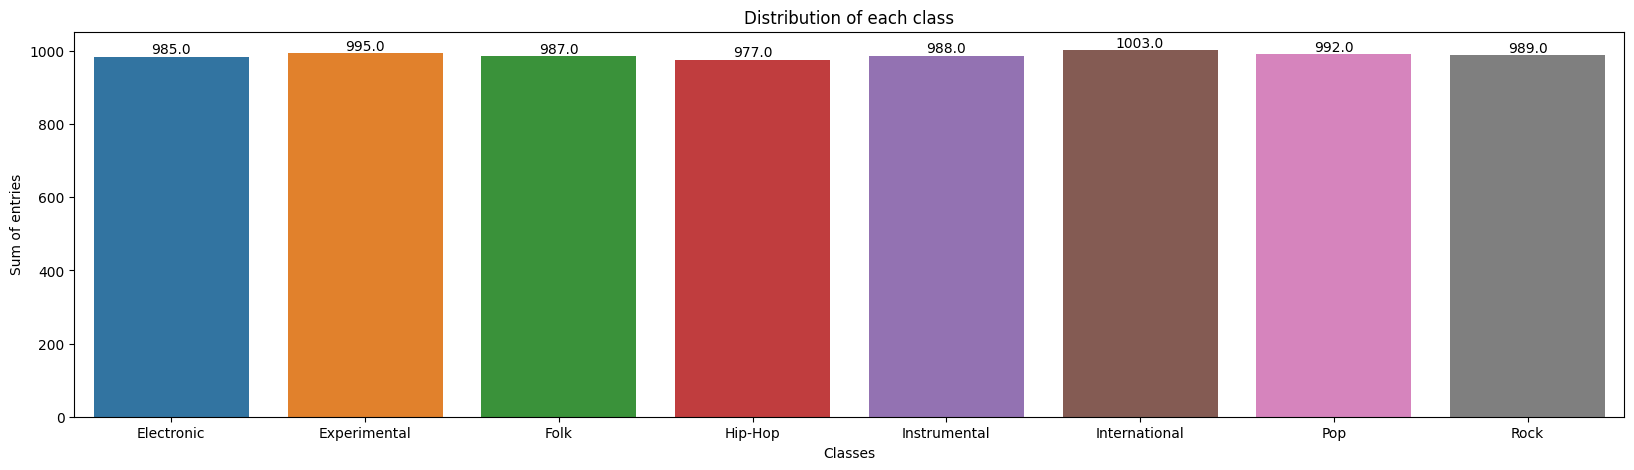

In [ ]:
# plot data frequency for the whole dataset
plt.figure(figsize=(20,5))
data = pd.DataFrame(data = {'class_name': all_classes_count.keys(), 'sum of entries': all_classes_count.values()})
data["sum of entries"] = data["sum of entries"].astype("int32")
ax = sns.barplot(data = data, x= "class_name", y="sum of entries")
ax.set(xlabel = "Classes", ylabel = "Sum of entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.title(f"Distribution of each class")
plt.show()

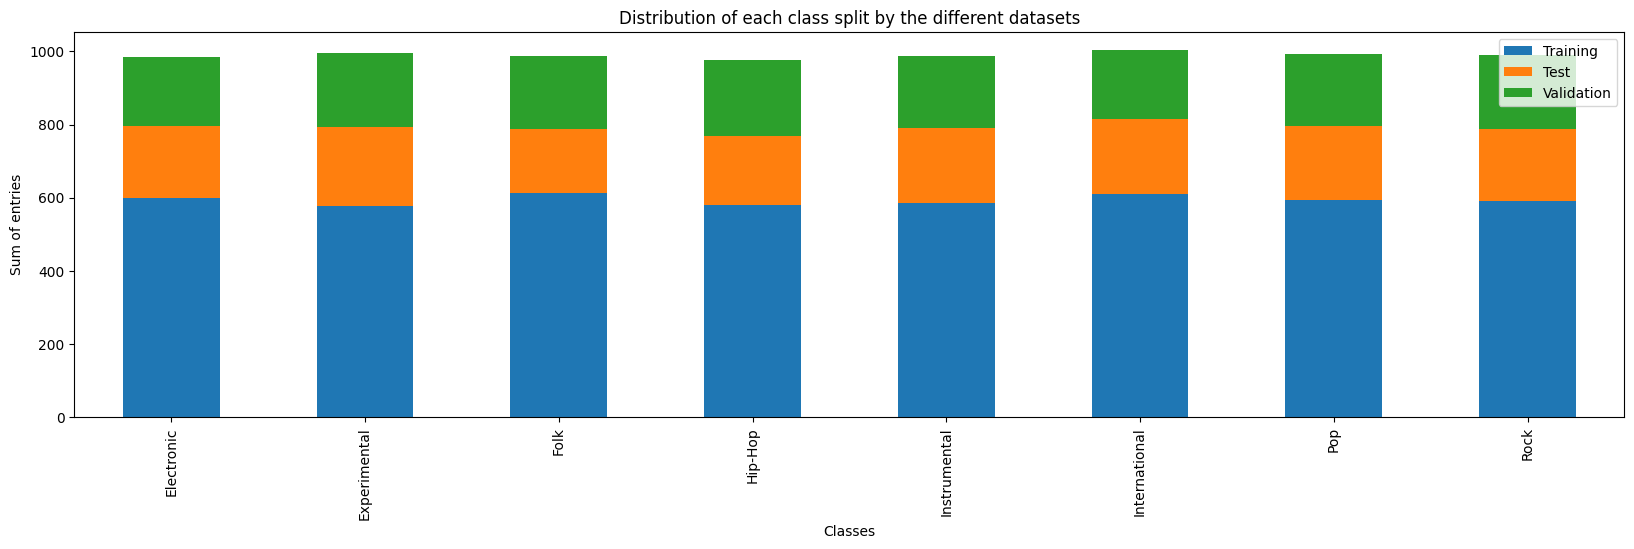

In [ ]:
# plot data frequency by set
df_counts_by_classes: pd.DataFrame = pd.DataFrame(dataset_number_of_occurences, index=CLASS_NAMES)
fig, axs = plt.subplots(figsize=(20,5))
axs.set_title(f"Distribution of each class split by the different datasets")
axs.set(xlabel = "Classes", ylabel = "Sum of entries")
df_counts_by_classes.plot(kind='bar', stacked=True, ax=axs)
fig.show()

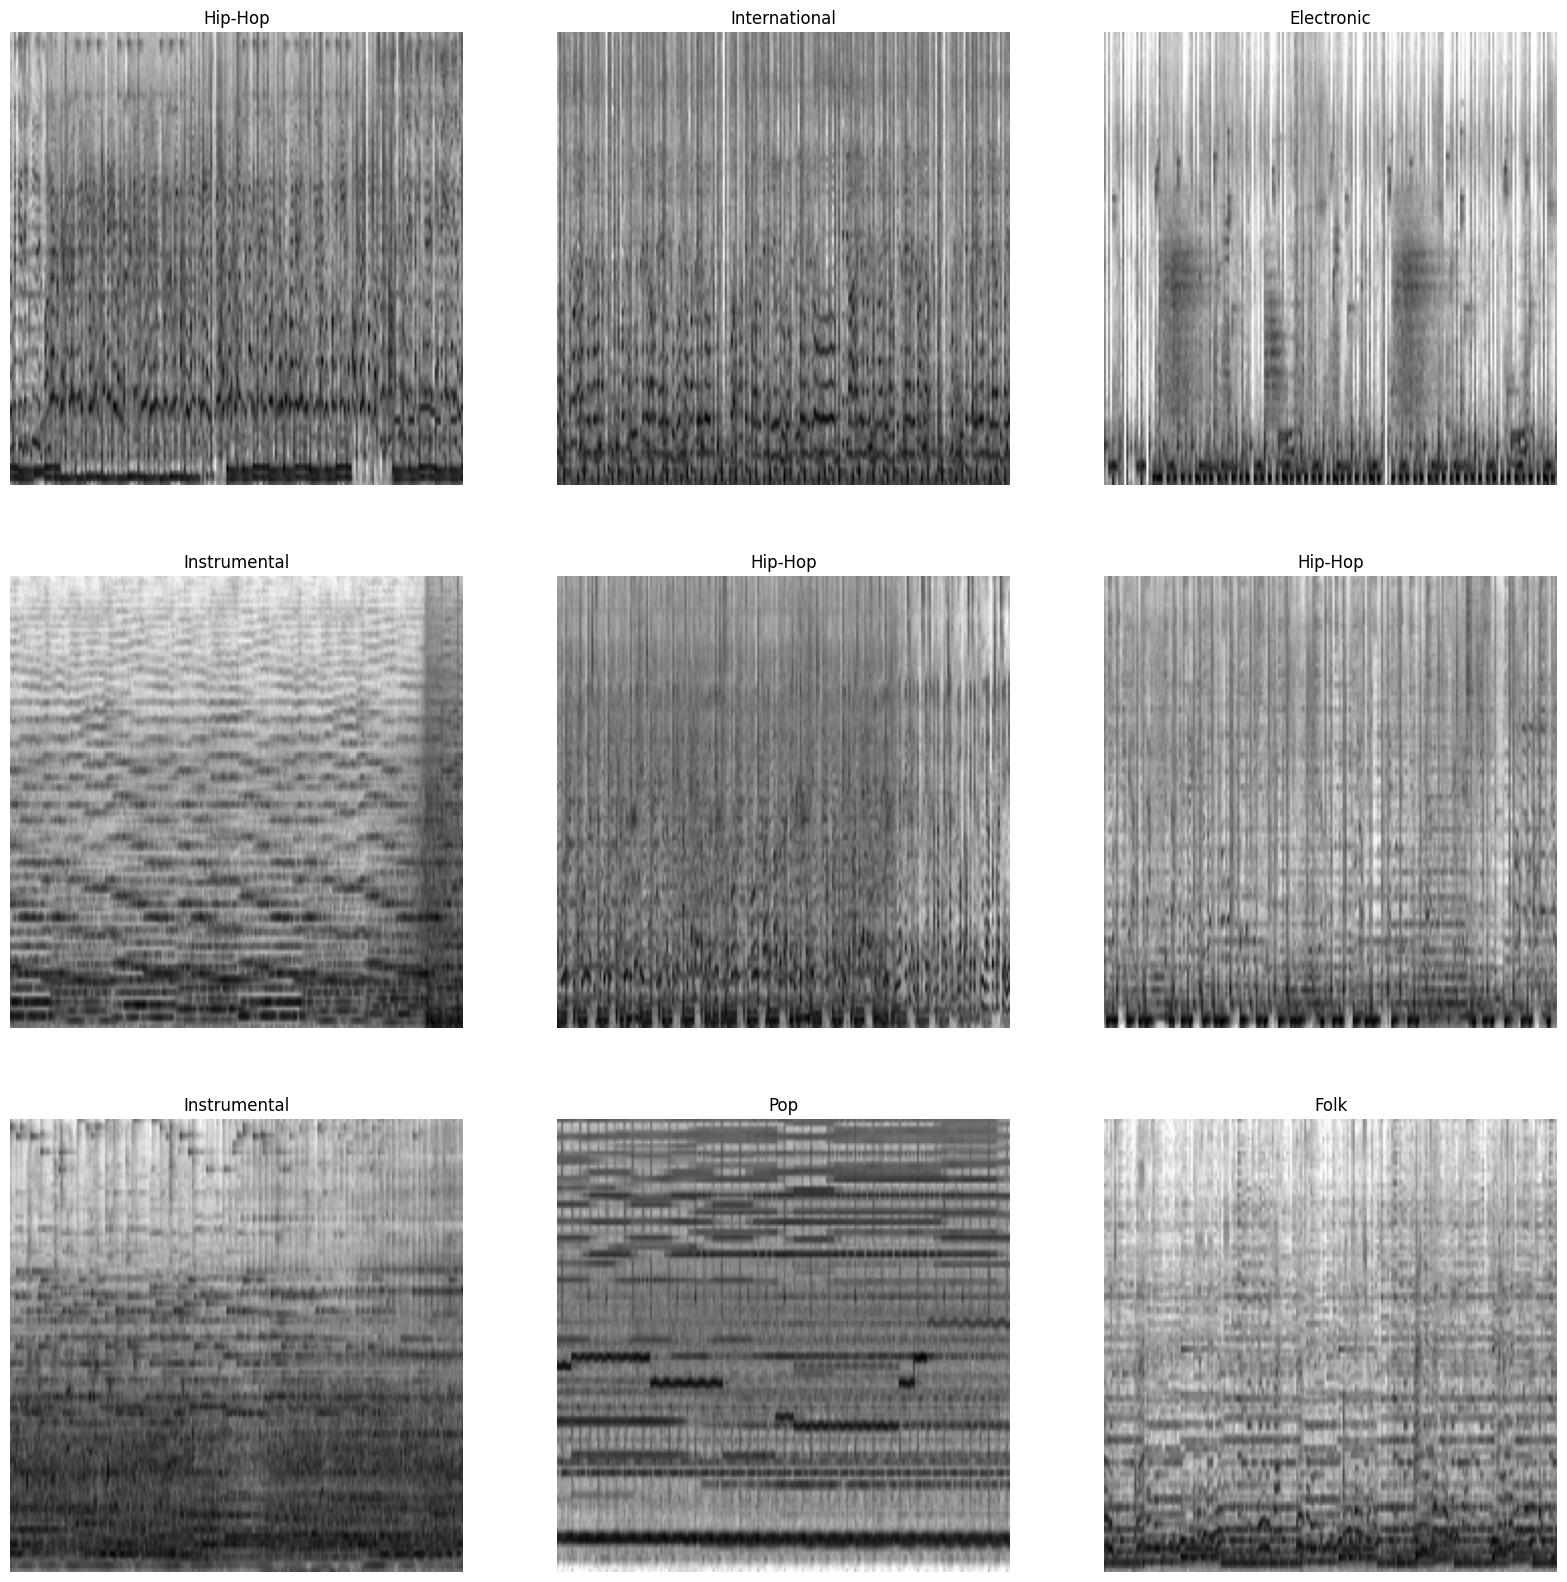

In [ ]:
# plot first 9 items of the training dataset
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
        plt.title(CLASS_NAMES[tf.argmax(labels[i])])
        plt.axis("off")

# 2 Modeltraining

## 2.1 General setup

In [ ]:
# function to store all images in an array out of the dataset generators,
#   because specifying y-label is not possible, if using tensorflow image
#   dataset --> original labels are the genres

def create_and_scale_images(datasets: list):
  images = np.array([])
  labels =  np.array([])
  for dataset in datasets:
    for batch, label in dataset:
        if len(images)==0:
            images = batch.numpy()
        else:
            images = np.concatenate([images, batch.numpy()])
        labels = np.concatenate([labels, np.argmax(label.numpy(), axis=-1)])
  # scale to range [0, 1]
  images /= 255.
  return images, labels

In [ ]:
# create datasets for the different models
train_test_split = True   # set to false if model version 2 or 3 should be trained
if train_test_split:
  images_train, labels_train = create_and_scale_images([train_ds, val_ds])
  images_test, labels_test = create_and_scale_images([test_ds])
  max_train = images_train.shape[0]//batch_size
  images_train = images_train[:max_train*batch_size, :, :, :]

  labels_train = labels_train[:max_train*batch_size]
  images_train.shape
else:
  images, labels = create_and_scale_images([train_ds, test_ds, val_ds])

## 2.2 First VAE-Modeltraining


### 2.2.1 Define the encoder and decoder networks with *tf.keras.Sequential*

In this VAE example, use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively. Use `tf.keras.Sequential` to simplify implementation. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

#### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$.
In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian.
Output log-variance instead of the variance directly for numerical stability.

#### Decoder network
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
Model the latent distribution prior $p(z)$ as a unit Gaussian.

#### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

#### Network architecture
For the encoder network, use four convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by five convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.


In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim

    self.encoder = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)),
        tf.keras.layers.Conv2D(
            filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(
            filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(
            filters=128, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(
            filters=256, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Flatten(),
        # No activation
        tf.keras.layers.Dense(latent_dim + latent_dim),

        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=14*14*256, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(14, 14, 256)),
            tf.keras.layers.Conv2DTranspose(
                filters=256, kernel_size=3, strides=(2, 2), padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=(2, 2), padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=(2, 2), padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=(2, 2), padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  # generate one sample (with the trained model)
  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  # encode input data
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  # reparametrisation of encoded data
  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  # decoding of latent-dimensional vector to original/ generated image
  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

### 2.2.2 Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

Note: You could also analytically compute the KL term, but here you incorporate all three terms in the Monte Carlo estimator for simplicity.

In [ ]:
# setup optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  # print(f"Loss: {float(loss)}")
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

### 2.2.3 Training


* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# Training setup
epochs = 50
latent_dim = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

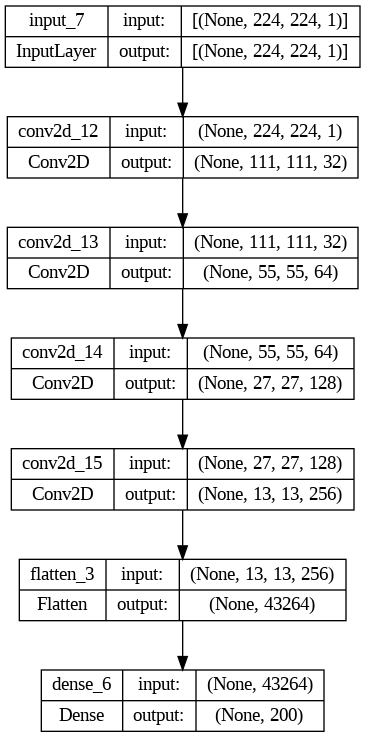

In [ ]:
# show encoder architecture
tf.keras.utils.plot_model(model.encoder, show_shapes=True, show_layer_names=True)

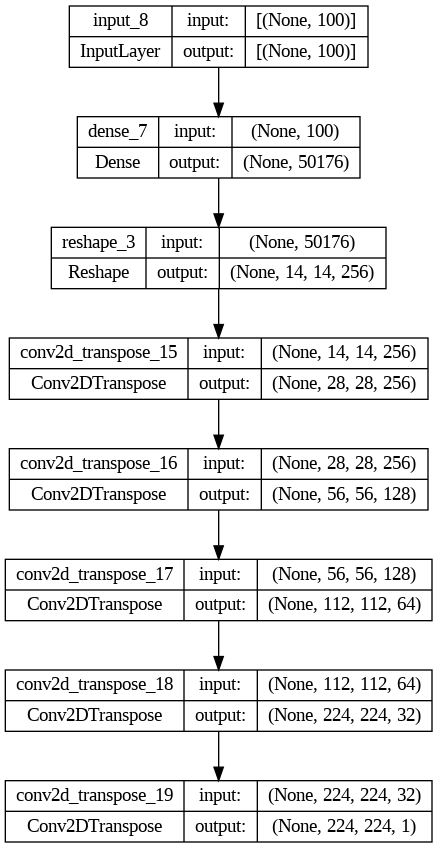

In [ ]:
# show decoder architecture
tf.keras.utils.plot_model(model.decoder, show_shapes=True, show_layer_names=True)

In [ ]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in images_test:
  test_sample = test_batch

test_sample.shape

In [ ]:
# reshape the images to specific batch size
images_test = np.reshape(images_test, (-1, batch_size, 224, 224, 1))
labels_test = np.reshape(labels_test, (-1, batch_size))
images_train = np.reshape(images_train, (-1, batch_size, 224, 224, 1))
labels_train = np.reshape(labels_train, (-1, batch_size))

Epoch: 50, Test set ELBO: -31783.9765625, time elapse for current epoch: 23.953040599822998


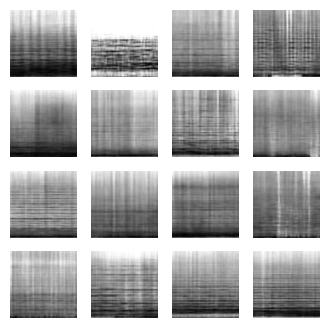

In [ ]:
# run training and display one image at the end of each epoche
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in images_train:
    # train_x /= 255.
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in images_test:
    # test_x /= 255.
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_x)

In [ ]:
# create a new directory for storing the model weights
! mkdir /content/drive/MyDrive/ASSModelh5/

mkdir: cannot create directory ‘/content/drive/MyDrive/ASSModelh5/’: File exists


In [ ]:
# store encoder weights
model.encoder.save("/content/drive/MyDrive/ASSModelh5/AEv1encoder", save_format="h5")
model.encoder.save("/content/drive/MyDrive/ASSModel/AEv1encoder")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# store decoder weights
model.decoder.save("/content/drive/MyDrive/ASSModelh5/AEv1decoder", save_format="h5")
model.decoder.save("/content/drive/MyDrive/ASSModel/AEv1decoder")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



### 2.2.4 Generating images


#### Display a generated image from the last training epoch

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

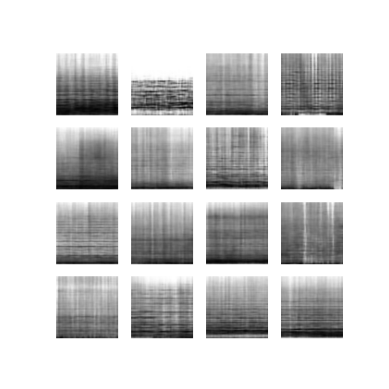

In [ ]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

#### Display an animated GIF of all the saved images

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-77-a6dbd3b71488>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-77-a6dbd3b71488>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



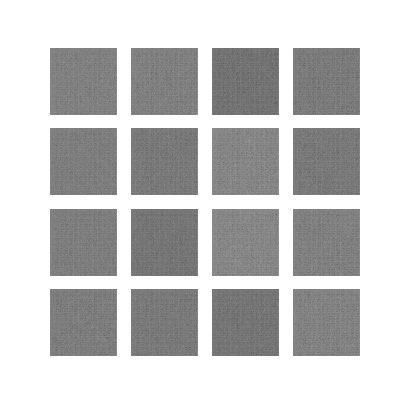

In [ ]:
embed.embed_file(anim_file)

#### Display sample encoded-decoded images of the test set

In [ ]:
# encode first 16 images
mean, logvar = model.encode(images[:16, :, :])
z = model.reparameterize(mean, logvar)
z.shape

TensorShape([16, 100])

In [ ]:
# reconstruct the images again
decoded = model.decode(z)
decoded.shape

TensorShape([16, 224, 224, 1])

In [ ]:
# compare minimum value of re-generated and original images
np.array(decoded).min(), images[:16, :, :].min()

(-2.4551196, 0.00019244026)

In [ ]:
# compare maximum value of re-generated and original images
#   -> for min and max re-generated values are much higher than original and
#   outside the input range of values between 0 and 1
np.array(decoded).max(), images[:16, :, :].max()

(9.919571, 1.0)

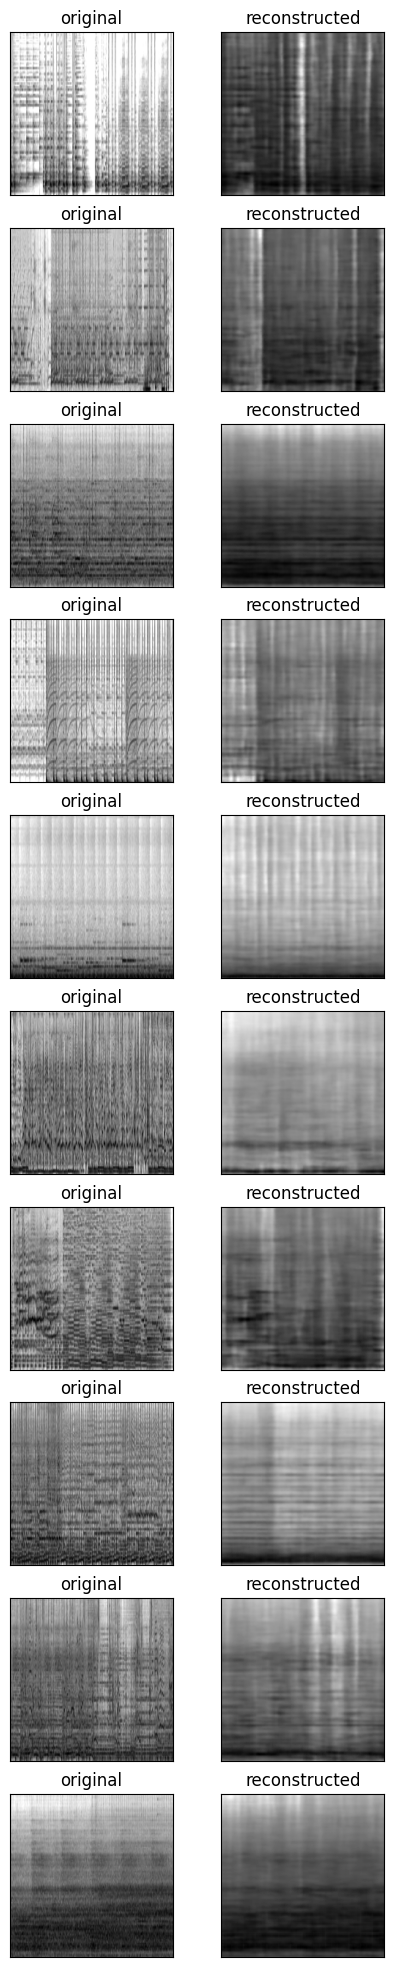

In [ ]:
# display five different original and reconstructed images

n = 10
plt.figure(figsize=(5, 25))
for i in range(n):
    # display original
    ax = plt.subplot(n, 2, 2*i+1)
    plt.imshow(images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(n, 2, 2*i+2)
    plt.imshow(decoded[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2.3 Second VAE-Modeltraining

### 2.3.1 Model setup

In [ ]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# create encoder model

def build_encoder(input_shape: Tuple, latent_dim: int = 100):

  encoder_input = tf.keras.layers.Input(shape=input_shape)
  x = tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation='relu')(encoder_input)
  x = tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation='relu')(x)
  x = tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation='relu')(x)
  x = tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation='relu')(x)
  x = tf.keras.layers.Flatten()(x)
    # No activation
    # tf.keras.layers.Dense(latent_dim + latent_dim),
  x = tf.keras.layers.Dense(latent_dim + latent_dim)(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

  return encoder

latent_dim = 100
encoder = build_encoder((IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS), latent_dim = latent_dim)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 111, 111, 32)         320       ['input_9[0][0]']             
                                                                                                  
 conv2d_17 (Conv2D)          (None, 55, 55, 64)           18496     ['conv2d_16[0][0]']           
                                                                                                  
 conv2d_18 (Conv2D)          (None, 27, 27, 128)          73856     ['conv2d_17[0][0]']           
                                                                                            

In [ ]:
# create decoder model part

def build_decoder(latent_dim = latent_dim):
    decoder_input = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(units=14*14*256, activation=tf.nn.relu)(decoder_input)
    x = tf.keras.layers.Reshape(target_shape=(14, 14, 256))(x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=256, kernel_size=3, strides=(2, 2), padding='same',
        activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding='same',
        activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding='same',
        activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding='same',
        activation='relu')(x)
    # No activation
    decoder_outputs = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=1, padding='same')(x)
    decoder = keras.Model(decoder_input, decoder_outputs, name="decoder")

    return decoder

decoder = build_decoder(latent_dim=latent_dim)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_9 (Dense)             (None, 50176)             5067776   
                                                                 
 reshape_4 (Reshape)         (None, 14, 14, 256)       0         
                                                                 
 conv2d_transpose_20 (Conv2  (None, 28, 28, 256)       590080    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_21 (Conv2  (None, 56, 56, 128)       295040    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_22 (Conv2  (None, 112, 112, 64)      7379

In [ ]:
# create VAE with encoder, decoder and custom train step method

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # multiply KL loss with 1000 so both losses are equally weighted
            # kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))*1000
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### 2.3.2 Modeltraining

In [ ]:
# Training parameter
EPOCHS = 150
EARLY_STOPPING_PATIENCE = 10 # math.sqrt(EPOCHS)

# setup early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=EARLY_STOPPING_PATIENCE,
                                                  verbose=2,
                                                  monitor="loss",
                                                  restore_best_weights=True)

In [ ]:
# create, compile and fit model
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))
vae.fit(images, epochs=EPOCHS, batch_size=32, callbacks=early_stopping)

In [ ]:
# create dir to store the model
! mkdir /content/drive/MyDrive/ASSModelh5/

In [ ]:
# save the encoder to google drive
vae.encoder.save("/content/drive/MyDrive/ASSModelh5/VAEv2encoder150epochsV2", save_format="h5")
vae.encoder.save("/content/drive/MyDrive/ASSModel/VAEv2encoder150epochsV2")

In [ ]:
# save the decoder model to google drive
vae.decoder.save("/content/drive/MyDrive/ASSModelh5/VAEv2decoder150epochV2", save_format="h5")
vae.decoder.save("/content/drive/MyDrive/ASSModel/VAEv2decoder150epochsV2")

### 2.3.3 Generate images

In [ ]:
# encode 16 images
z_mean, z_log_var, z = vae.encoder.predict(images[:16, :, :])
z.shape

1/1 [==============================] - 0s 33ms/step


(16, 100)

In [ ]:
# decode encoded images
decoded = vae.decoder.predict(z)
decoded.shape

1/1 [==============================] - 0s 20ms/step


(16, 224, 224, 1)

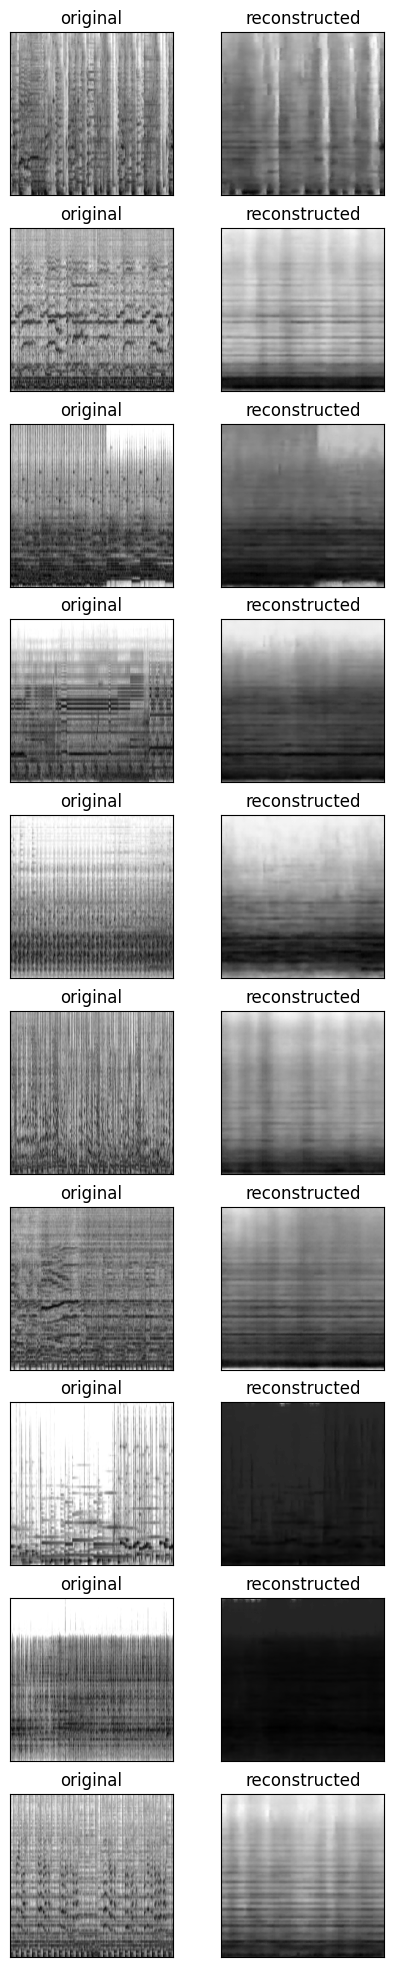

In [ ]:
# plot first 10 occurences of the dataset
n = 10
plt.figure(figsize=(5, 25))
for i in range(n):
    # display original
    ax = plt.subplot(n, 2, 2*i+1)
    plt.imshow(images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(n, 2, 2*i+2)
    plt.imshow(decoded[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2.4 Autoencoder-Modeltraining

### 2.4.1 Model setup

In [ ]:
# define encoder model

def build_encoder(input_shape: Tuple, latent_dim: int = 100):

  encoder_input = tf.keras.layers.Input(shape=input_shape)
  x = tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation='relu')(encoder_input)
  x = tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation='relu')(x)
  x = tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation='relu')(x)
  x = tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation='relu')(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(latent_dim)(x)
  encoder = tf.keras.Model(inputs=encoder_input, outputs=x, name="encoder")

  return encoder

latent_dim = 100
encoder = build_encoder((IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS), latent_dim = latent_dim)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 111, 111, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 55, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 43264)             0         
                                                                 
 dense (Dense)               (None, 100)               4326

In [ ]:
# define decoder model

def build_decoder(latent_dim = latent_dim):
    decoder_input = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(units=14*14*256, activation=tf.nn.relu)(decoder_input)
    x = tf.keras.layers.Reshape(target_shape=(14, 14, 256))(x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=256, kernel_size=3, strides=(2, 2), padding='same',
        activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding='same',
        activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding='same',
        activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding='same',
        activation='relu')(x)
    # No activation
    decoder_outputs = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=1, padding='same')(x)
    decoder = tf.keras.Model(decoder_input, decoder_outputs, name="decoder")

    return decoder

decoder = build_decoder(latent_dim=latent_dim)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 50176)             5067776   
                                                                 
 reshape (Reshape)           (None, 14, 14, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 28, 28, 256)       590080    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 56, 56, 128)       295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 112, 112, 64)      7379

In [ ]:
# create class autoencoder with encoder and decoder and custom call function

class Autoencoder(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(encoder, decoder)

### 2.4.2 Modeltraining

In [ ]:
# Training parameter
EPOCHS = 50
EARLY_STOPPING_PATIENCE = math.sqrt(EPOCHS)

# setup early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=EARLY_STOPPING_PATIENCE,
                                                  verbose=2,
                                                  restore_best_weights=True)

In [ ]:
# compile and fit the model
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
autoencoder.fit(images, images, epochs=EPOCHS, shuffle=True, batch_size=16,
                callbacks=early_stopping)

Epoch 1/50
297/297 [==============================] - ETA: 0s - loss: 0.0493

297/297 [==============================] - 36s 68ms/step - loss: 0.0493
Epoch 2/50
297/297 [==============================] - ETA: 0s - loss: 0.0130

297/297 [==============================] - 19s 64ms/step - loss: 0.0130
Epoch 3/50
297/297 [==============================] - ETA: 0s - loss: 0.0117

297/297 [==============================] - 19s 63ms/step - loss: 0.0117
Epoch 4/50
297/297 [==============================] - ETA: 0s - loss: 0.0111

297/297 [==============================] - 18s 62ms/step - loss: 0.0111
Epoch 5/50
297/297 [==============================] - ETA: 0s - loss: 0.0108

297/297 [==============================] - 18s 62ms/step - loss: 0.0108
Epoch 6/50
297/297 [==============================] - ETA: 0s - loss: 0.0105

297/297 [==============================] - 18s 62ms/step - loss: 0.0105
Epoch 7/50
297/297 [==============================] - ETA: 0s - loss: 0.0103

297/297 [==============================] - 19s 63ms/step - loss: 0.0103
Epoch 8/50
297/297 [==============================] - ETA: 0s - loss: 0.0103

297/297 [==============================] - 18s 62ms/step - loss: 0.0103
Epoch 9/50
297/297 [==============================] - ETA: 0s - loss: 0.0100

297/297 [==============================] - 18s 62ms/step - loss: 0.0100
Epoch 10/50
297/297 [==============================] - ETA: 0s - loss: 0.0099

297/297 [==============================] - 19s 62ms/step - loss: 0.0099
Epoch 11/50
297/297 [==============================] - ETA: 0s - loss: 0.0097

297/297 [==============================] - 18s 62ms/step - loss: 0.0097
Epoch 12/50
297/297 [==============================] - ETA: 0s - loss: 0.0096

297/297 [==============================] - 19s 63ms/step - loss: 0.0096
Epoch 13/50
297/297 [==============================] - ETA: 0s - loss: 0.0095

297/297 [==============================] - 19s 62ms/step - loss: 0.0095
Epoch 14/50
297/297 [==============================] - ETA: 0s - loss: 0.0094

297/297 [==============================] - 19s 62ms/step - loss: 0.0094
Epoch 15/50
297/297 [==============================] - ETA: 0s - loss: 0.0093

297/297 [==============================] - 18s 62ms/step - loss: 0.0093
Epoch 16/50
297/297 [==============================] - ETA: 0s - loss: 0.0094

297/297 [==============================] - 18s 62ms/step - loss: 0.0094
Epoch 17/50
297/297 [==============================] - ETA: 0s - loss: 0.0090

297/297 [==============================] - 18s 62ms/step - loss: 0.0090
Epoch 18/50
297/297 [==============================] - ETA: 0s - loss: 0.0089

297/297 [==============================] - 18s 62ms/step - loss: 0.0089
Epoch 19/50
297/297 [==============================] - ETA: 0s - loss: 0.0089

297/297 [==============================] - 18s 62ms/step - loss: 0.0089
Epoch 20/50
297/297 [==============================] - ETA: 0s - loss: 0.0088

297/297 [==============================] - 18s 62ms/step - loss: 0.0088
Epoch 21/50
297/297 [==============================] - ETA: 0s - loss: 0.0087

297/297 [==============================] - 18s 62ms/step - loss: 0.0087
Epoch 22/50
297/297 [==============================] - ETA: 0s - loss: 0.0086

297/297 [==============================] - 18s 62ms/step - loss: 0.0086
Epoch 23/50
297/297 [==============================] - ETA: 0s - loss: 0.0084

297/297 [==============================] - 18s 62ms/step - loss: 0.0084
Epoch 24/50
297/297 [==============================] - ETA: 0s - loss: 0.0083

297/297 [==============================] - 18s 62ms/step - loss: 0.0083
Epoch 25/50
297/297 [==============================] - ETA: 0s - loss: 0.0081

297/297 [==============================] - 18s 62ms/step - loss: 0.0081
Epoch 26/50
297/297 [==============================] - ETA: 0s - loss: 0.0082

297/297 [==============================] - 18s 62ms/step - loss: 0.0082
Epoch 27/50
297/297 [==============================] - ETA: 0s - loss: 0.0080

297/297 [==============================] - 19s 63ms/step - loss: 0.0080
Epoch 28/50
297/297 [==============================] - ETA: 0s - loss: 0.0078

297/297 [==============================] - 18s 62ms/step - loss: 0.0078
Epoch 29/50
297/297 [==============================] - ETA: 0s - loss: 0.0077

297/297 [==============================] - 18s 62ms/step - loss: 0.0077
Epoch 30/50
297/297 [==============================] - ETA: 0s - loss: 0.0079

297/297 [==============================] - 18s 62ms/step - loss: 0.0079
Epoch 31/50
297/297 [==============================] - ETA: 0s - loss: 0.0076

297/297 [==============================] - 19s 62ms/step - loss: 0.0076
Epoch 32/50
297/297 [==============================] - ETA: 0s - loss: 0.0076

297/297 [==============================] - 19s 63ms/step - loss: 0.0076
Epoch 33/50
297/297 [==============================] - ETA: 0s - loss: 0.0074

297/297 [==============================] - 18s 62ms/step - loss: 0.0074
Epoch 34/50
297/297 [==============================] - ETA: 0s - loss: 0.0073

297/297 [==============================] - 18s 62ms/step - loss: 0.0073
Epoch 35/50
297/297 [==============================] - ETA: 0s - loss: 0.0072

297/297 [==============================] - 19s 63ms/step - loss: 0.0072
Epoch 36/50
297/297 [==============================] - ETA: 0s - loss: 0.0072

297/297 [==============================] - 18s 62ms/step - loss: 0.0072
Epoch 37/50
297/297 [==============================] - ETA: 0s - loss: 0.0070

297/297 [==============================] - 18s 62ms/step - loss: 0.0070
Epoch 38/50
297/297 [==============================] - ETA: 0s - loss: 0.0071

297/297 [==============================] - 19s 62ms/step - loss: 0.0071
Epoch 39/50
297/297 [==============================] - ETA: 0s - loss: 0.0069

297/297 [==============================] - 18s 62ms/step - loss: 0.0069
Epoch 40/50
297/297 [==============================] - ETA: 0s - loss: 0.0068

297/297 [==============================] - 19s 62ms/step - loss: 0.0068
Epoch 41/50
297/297 [==============================] - ETA: 0s - loss: 0.0068

297/297 [==============================] - 19s 62ms/step - loss: 0.0068
Epoch 42/50
297/297 [==============================] - ETA: 0s - loss: 0.0067

297/297 [==============================] - 18s 62ms/step - loss: 0.0067
Epoch 43/50
297/297 [==============================] - ETA: 0s - loss: 0.0066

297/297 [==============================] - 18s 62ms/step - loss: 0.0066
Epoch 44/50
297/297 [==============================] - ETA: 0s - loss: 0.0067

297/297 [==============================] - 19s 62ms/step - loss: 0.0067
Epoch 45/50
297/297 [==============================] - ETA: 0s - loss: 0.0066

297/297 [==============================] - 18s 62ms/step - loss: 0.0066
Epoch 46/50
297/297 [==============================] - ETA: 0s - loss: 0.0066

297/297 [==============================] - 19s 62ms/step - loss: 0.0066
Epoch 47/50
297/297 [==============================] - ETA: 0s - loss: 0.0065

297/297 [==============================] - 18s 62ms/step - loss: 0.0065
Epoch 48/50
297/297 [==============================] - ETA: 0s - loss: 0.0063

297/297 [==============================] - 19s 63ms/step - loss: 0.0063
Epoch 49/50
297/297 [==============================] - ETA: 0s - loss: 0.0063

297/297 [==============================] - 18s 62ms/step - loss: 0.0063
Epoch 50/50
297/297 [==============================] - ETA: 0s - loss: 0.0063

297/297 [==============================] - 18s 62ms/step - loss: 0.0063


### 2.4.3 Generating images
as first visual model test

In [ ]:
# encode first 16 images
encoded = autoencoder.encoder.predict(images[:16, :, :])
encoded.shape

1/1 [==============================] - 0s 148ms/step


(16, 100)

In [ ]:
# decode the encoded images
decoded = autoencoder.decoder.predict(encoded)
decoded.shape

1/1 [==============================] - 0s 212ms/step


(16, 224, 224, 1)

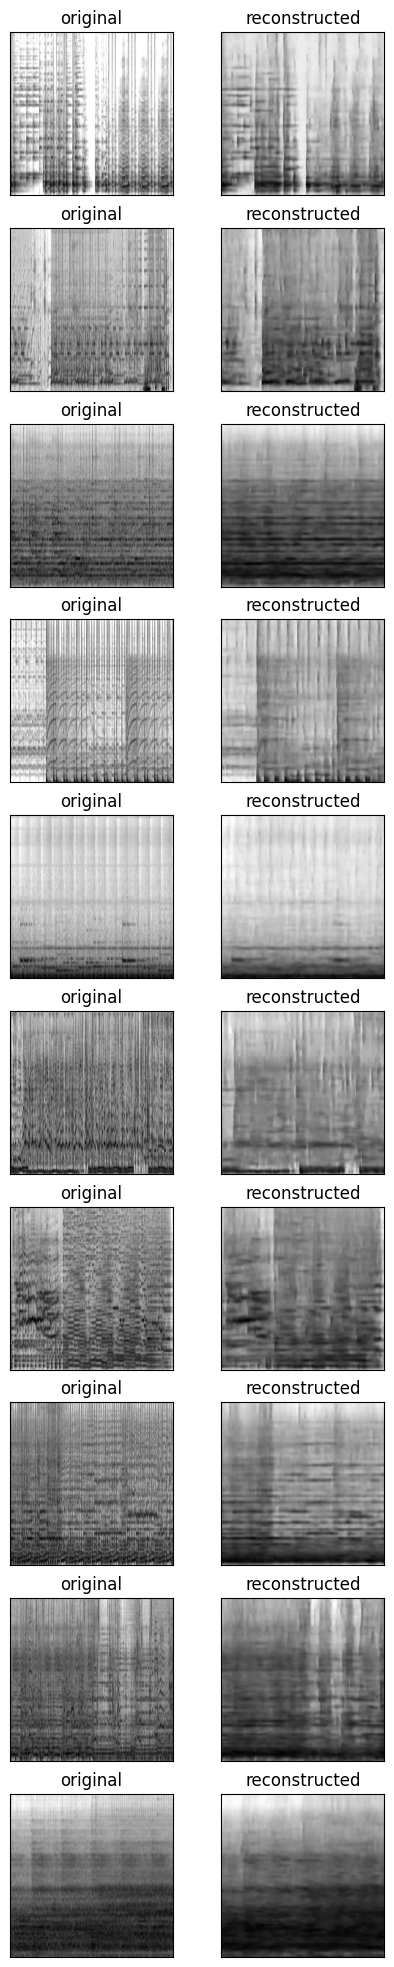

In [ ]:
# plot first 10 occurences of the dataset
n = 10
plt.figure(figsize=(5, 25))
for i in range(n):
    # display original
    ax = plt.subplot(n, 2, 2*i+1)
    plt.imshow(images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(n, 2, 2*i+2)
    plt.imshow(decoded[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# create dir to store the model
! mkdir /content/drive/MyDrive/ASSModelh5/

mkdir: cannot create directory ‘/content/drive/MyDrive/ASSModelh5/’: File exists


In [ ]:
# save the encoder to google drive
autoencoder.encoder.save("/content/drive/MyDrive/ASSModelh5/AEv3encoder", save_format="h5")
autoencoder.encoder.save("/content/drive/MyDrive/ASSModel/AEv3encoder")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# save the decoder to google drive
autoencoder.decoder.save("/content/drive/MyDrive/ASSModelh5/AEv3decoder", save_format="h5")
autoencoder.decoder.save("/content/drive/MyDrive/ASSModel/AEv3decoder")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
